This notebook creates model training data for Mexico. The farm locations (label=1) are obtained from the Mexican government dataset, and random large buildings not associated with CAFOs are used as the not-farm locations (label=0). Regions of Sentinel data are extracted around each farm and not-farm location, and saved as numpy arrays that can then be read in by the trainCNN notebook.

Currently, chicken, egg, and pig farms are lumped together into the CAFO category, and dairies and feedlots are dropped.The notebook must be run manually for every state of interest - this could be automated, but it has been valuable to inspect the maps and images created for each state.

Setup. Run the first 5 cells at the start of every session, uncommenting as necessary.

In [ ]:
"""
!pip install -q condacolab
import condacolab
condacolab.install()
"""

⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.11.0-0/Mambaforge-23.11.0-0-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:24
🔁 Restarting kernel...


In [ ]:
"""
import condacolab
condacolab.check()
"""

✨🍰✨ Everything looks OK!


In [ ]:
!conda install pyogrio=0.7.2 geopandas=0.14.3 unidecode

In [ ]:
import os
from unidecode import unidecode
import numpy as np
import scipy.ndimage
import matplotlib.pyplot as plt
from google.colab import drive
import ee
import geemap.foliumap as geemap
import pandas as pd
import geopandas as gpd
import pyarrow

gpd.options.io_engine = "pyogrio"
os.environ["PYOGRIO_USE_ARROW"] = "1"

In [ ]:
ee.Authenticate()
ee.Initialize(project="215656163750")
drive.mount('/content/drive')

Mounted at /content/drive


Define key variables that will be used throughout

In [ ]:
min_building_size = 1000

sentinel_bands = ['B4', 'B3', 'B2'] # mainly to reduce data volume/get max resolution
                                    # keep bands in this order

training_image_radius = 240 # m, to obtain (approx) 48 x ?? pixel images

Define some basic functions for getting hold of the necessary data: shapefiles, building footprints, Sentinel data, government farm records

In [ ]:
# Shapefile of Mexican states, from
# https://data.humdata.org/dataset/cod-ab-mex

def get_state_boundary(state):
  boundaries = gpd.read_file(
      "/content/drive/MyDrive/CAFO_data/Mexico/mex_admbnda_adm1_govmex_20210618.shp"
  )

  boundary = boundaries[boundaries['ADM1_ES'].str.match(state)]
  boundary = geemap.geopandas_to_ee(boundary[['geometry']])

  return boundary

In [ ]:
# The MS-Google combined building footprint dataset for Mexico --> state of interest

def get_building_footprints(boundary, min_building_size):
  buildings = (
      #get all buildings in Mexico
      ee.FeatureCollection("projects/sat-io/open-datasets/VIDA_COMBINED/MEX")
      #keep only buildings within relevant state boundaries
      .filterBounds(boundary)
      #keep only buildings above min_building_size
      .filter(ee.Filter.gt('area_in_meters', min_building_size))
      )

  num = buildings.size().getInfo()

  return buildings, num

In [ ]:
# Sentinel data for region of interest
# Data for 2020, because the infrastructure dataset (next cell) appears to be from 2021
#   - May be better to use an earlier year in the hope of excluding unregistered CAFOs,
#     which might be post-2021?
#   - May be better to restrict to a certain season
#   - May need to use better cloud masking:
# https://developers.google.com/earth-engine/tutorials/community/sentinel-2-s2cloudless

def get_sentinel(boundary, sentinel_bands):
  sentinel = (
      ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
      .filterDate('2020-01-01', '2020-12-31')
      .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10))
      .select(sentinel_bands)
      .median() #crude cloud filter
      .clip(boundary)
  )

  return sentinel

In [ ]:
# Official Mexican Government records of animal farms
# These data supply coordinates of each farm, separated by farm type
#
# Available farm types are:
#  - "Granjas pollo "  <-- note trailing space
#  - "Granjas porcinos"
#  - "Granjas huevo"
#  - "Corrales de Engorda"
#  - "Establos lecheros"
#  - "Unidades ovinas"
#  - "Centro de Sacrificio"

def get_mexico_farms(state):

  # Get sheet_name: df dict
  df_dict = pd.read_excel(
      "/content/drive/MyDrive/CAFO_data/Mexico/Infraestructura pecuaria 2021.xlsx",
      sheet_name=None,
      header=3
      )

  fc_dict = {}
  for farm_type, df in df_dict.items():
    df = df[df["Nombre del Estado"].str.match(state)]

    gdf = gpd.GeoDataFrame(
        df,
        geometry=gpd.points_from_xy(
            df["Coordenada geográfica X"],
            df["Coordenada geográfica Y"]
            ), crs="EPSG:4326"
        )

    n_farms = len(gdf)
    farms = geemap.geopandas_to_ee(gdf[['geometry']])
    fc_dict[farm_type] = (n_farms, farms)

  return fc_dict

Create (or load) a dataframe that gives building numbers (> min_building_size) and farm numbers for each state. This is useful because some states (e.g. Baja California) have so many large buildings that GEE won't handle them (computations time out), but only a handful of farms. So it may make sense to exclude those states.

In [ ]:
"""
mexican_states = ["Aguascalientes", "Baja California", "Baja California Sur", "Campeche",
                  "Chiapas", "Chihuahua", "Coahuila de Zaragoza", "Colima", "Durango",
                  "Guanajuato", "Guerrero", "Hidalgo", "Jalisco", "México", "Cuidad de México",
                  "Michoacán de Ocampo", "Morelos", "Nayarit", "Nuevo León", "Oaxaca",
                  "Puebla", "Querétaro", "Quintana Roo", "San Luis Potosí", "Sinaloa",
                  "Sonora", "Tabasco", "Tamaulipas", "Tlaxcala", "Veracruz de Ignacio de la Llave",
                  "Yucatán", "Zacatecas"]

info = pd.DataFrame()
for state in mexican_states:
  if state in ["Jalisco", "México", "Cuidad de México"]:
    # Jalisco just has too many buildings, suspect these others do as well
    continue
  print(f"Analyzing {state}")
  boundary = get_state_boundary(state)
  _, num = get_building_footprints(boundary, min_building_size)
  info.loc[state, 'num'] = num
  farm_dict = get_mexico_farms(state)
  for farm_type, (n_farms, _) in farm_dict.items():
    info.loc[state, farm_type] = n_farms

info.astype(int).to_pickle("/content/drive/MyDrive/CAFO_data/Mexico/info_df.pkl")
"""

In [ ]:
# Get info about CAFOs per state
# Combine pig, chicken, and egg farms, drop others (for now)
# Calculate total pig+chicken+egg CAFOs and CAFOs/total buildings
# Sort by number of CAFOs
# This shows which states are worth bothering with; some have very few CAFOs,
# and they might also have a very large number of buildings, which makes them
# slow or impractical to process

info = pd.read_pickle("/content/drive/MyDrive/CAFO_data/Mexico/info_df.pkl")
info.drop(columns=['Unidades ovinas', 'Centro de Sacrificio',\
                   'Corrales de Engorda', 'Establos lecheros'], inplace=True)
info['CAFOs'] = info['Granjas porcinos'] + info['Granjas pollo '] +\
                info['Granjas huevo']
info['bldgs:CAFOs'] = (info['num'] / info['CAFOs']).round(0)
display(info.sort_values('CAFOs', ascending=False))

/usr/local/lib/python3.10/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,num,Granjas pollo,Granjas porcinos,Granjas huevo,CAFOs,bldgs:CAFOs
Sonora,11071,7,321,84,412,27.0
Guanajuato,20328,75,126,27,228,89.0
Aguascalientes,4813,82,122,5,209,23.0
Yucatán,5708,52,122,28,202,28.0
Querétaro,8931,156,38,3,197,45.0
Durango,5702,136,28,21,185,31.0
Chiapas,6721,98,74,4,176,38.0
Nuevo León,15466,39,43,40,122,127.0
Hidalgo,8619,81,35,2,118,73.0
Sinaloa,10531,45,36,29,110,96.0


State-by-state processing begins here. The following cells are where the farm and not-farm locations are identified, Sentinel data obtained, and numpy image arrays created. In the next cell, set the name of the state of interest.

In [ ]:
# Begin processing individual states - actually getting the training (Sentinel) data for each one

state = "Guanajuato"

if state in ["Coahuila de Zaragoza", "Veracruz de Ignacio de la Llave", "Michoacán de Ocampo"]:
  prefix = unidecode(state.split()[0])
else:
  prefix = unidecode(state).replace(" ", "")
print(f"File prefix will be: {prefix}")

# Aguascalientes| Baja California | Baja California Sur | Campeche | Chiapas | Chihuahua|
# Coahuila de Zaragoza | Colima | Durango | Guanajuato | Guerrero | Hidalgo | Jalisco |
# México | Cuidad de México | Michoacán de Ocampo | Morelos | Nayarit | Nuevo León | Oaxaca |
# Puebla | Querétaro | Quintana Roo| San Luis Potosí | Sinaloa | Sonora | Tabasco |
# Tamaulipas | Tlaxcala | Veracruz de Ignacio de la Llave | Yucatán| Zacatecas

File prefix will be: Guanajuato


In [ ]:
boundary = get_state_boundary(state)
buildings, num = get_building_footprints(boundary, min_building_size)
print(f"There are {num} buildings > {min_building_size} sq m in {state}")
sentinel = get_sentinel(boundary, sentinel_bands)
farm_dict = get_mexico_farms(state)

cafo_coords = farm_dict['Granjas porcinos'][1].merge(farm_dict['Granjas pollo '][1])
cafo_coords = cafo_coords.merge(farm_dict['Granjas huevo'][1])

There are 20328 buildings > 1000 sq m in Guanajuato


In [ ]:
Map = geemap.Map()
Map.centerObject(boundary.first().geometry(), 12)

os.environ["HYBRID"] = 'https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}'

sentinel_viz = {
    'min': 0,
    'max': 2000,
    'bands': sentinel_bands
}

buildings_viz = {
    'color': 'blue',
    'width': 2,
    'lineType': 'solid',
    'fillColor': '00000000' #transparent
}

Map.add_basemap("HYBRID")
Map.addLayer(sentinel, sentinel_viz, 'Sentinel')
Map.addLayer(buildings, buildings_viz, "Buildings")
Map.addLayer(farm_dict['Granjas porcinos'][1], {'color':'pink', 'width':6}, "Pig farms")
Map.addLayer(farm_dict['Granjas pollo '][1], {'color':'red', 'width':6}, "Chicken farms")
Map.addLayer(farm_dict['Granjas huevo'][1], {'color':'cyan', 'width':6}, "Egg farms")
Map.addLayer(farm_dict['Establos lecheros'][1], {'color':'yellow', 'width':6}, "Dairy farms")
Map.addLayer(farm_dict['Corrales de Engorda'][1], {'color':'limegreen', 'width':6}, 'Feedlots')
Map.addLayer(cafo_coords, {'color':'purple', 'width':6}, 'Pig+chicken+egg')


Map

In [ ]:
# Determine which large buildings are close to pig/chicken/egg farm coords.
# These are the only ones we want in the training dataset with label=1. Other buildings
# are not in large CAFOs, or are >100 m from official CAFO coords.

def filter_and_join(data1, data2, distance):

  # Define a spatial filter
  distFilter = ee.Filter.withinDistance(
      distance = distance,
      leftField = '.geo',
      rightField =  '.geo',
      maxError = 10
  )

  # Define a saveBest join.
  distSaveBest = ee.Join.saveBest(
      matchKey = 'points',
      measureKey = 'distance',
      outer = True
  )

  # Apply the join to create fc of <data1> and distance to closest item in <data2>
  # within <distance> (if any)
  spatialJoined = distSaveBest.apply(data1, data2, distFilter)

  return spatialJoined

# Select the CAFOs that have large buildings within 100 m of official coords
spatialJoined = filter_and_join(buildings, cafo_coords, 100)
cafo_bldgs = spatialJoined.filter(ee.Filter.notNull(['points']))
n = cafo_bldgs.size().getInfo()

print(f"There were {info.loc[state]['CAFOs'].astype(int)} CAFOs in the official dataset")
print(f"We have recovered {n} large buildings within 100 m of CAFO coords")


There were 228 CAFOs in the official dataset
We have recovered 609 large buildings within 100 m of CAFO coords


In [ ]:
# Get the Sentinel data for an area around each CAFO

# Define a square region around the building and extract Sentinel data
def get_sentinel_data(which_buildings, filename=None):

  # As there may be several buildings on a farm, group them all together
  # and define a square region around the centroid of the group

  # First, add a buffer around each building then dissolve all overlapping
  # (buffered) buildings into a single polygon (actually, an element of a
  # multipolygon that contains all such polygons in the farm dataset)
  def buffer_features(feature):
    buffer_radius = 100  # meters
    return feature.centroid().buffer(buffer_radius, 2)

  buffers = which_buildings.map(buffer_features)
  multipoly = buffers.geometry().dissolve()

  # Convert that multipolygon into a featureCollection of polygons
  fc = ee.FeatureCollection([
    ee.Feature(multipoly)
  ])

  fc = ee.List(fc.toList(fc.size()).map(lambda feature:
    ee.List(ee.Feature(feature).geometry().geometries()).map(lambda geom:
      ee.Feature(ee.Geometry(geom))
    )
  )).flatten()

  fc = ee.FeatureCollection(fc)

  # For each polygon (i.e., farm), define a square region around its centroid
  def buffer_and_bound(feature, buffer_radius=training_image_radius):
    return feature.centroid().buffer(buffer_radius, 2).bounds()

  areas = fc.map(buffer_and_bound)

  # Obtain Sentinel data for the farm polygons, save to file
  pix = sentinel.sampleRegions(
      collection=areas,
      scale=10,
      geometries=True)

  if filename is not None:
    task = ee.batch.Export.table.toDrive(
        collection=pix,
        description=filename,
        folder='Mexico',
        fileFormat='GeoJSON',
    )

    task.start()

  return areas

cafo_areas = get_sentinel_data(cafo_bldgs, filename=f"{prefix}_CAFOs")
n = cafo_areas.size().getInfo()
print(f"After merging closely-spaced buildings, there are {n} CAFOs in the dataset")

After merging closely-spaced buildings, there are 157 CAFOs in the dataset


In [ ]:
# Now, determine which large buildings do not have a CAFO nearby.
# We will increase the distance parameter so as to reduce the number of buildings
# that are actually just CAFOs whose official coords are offset from their buildings
# Our non-CAFO category will consist of a random sample of the large, non-CAFO
# buildings. The sample size will be a bit larger than the size of the CAFO dataset,
# as some buildings will be merged and some false negatives removed later.

# NB Yucatan was run with n*1.2, rerunning with a different value will require
# re-checking all the images

print(f"There are {n} CAFOs in the dataset --> sampling {n*1.5:.0f} not-CAFO buildings")
spatialJoined = filter_and_join(buildings, cafo_coords, 1000)
fc = spatialJoined.filter(ee.Filter.eq('points', None))
other_buildings = fc.randomColumn(seed=0).sort('random').limit(np.round(n*1.3, 0))

not_cafo_areas = get_sentinel_data(other_buildings, filename=f"{prefix}_NotCAFOs")
n = not_cafo_areas.size().getInfo()
print(f"After merging closely-spaced buildings, there are {n} not-CAFOs in the dataset")

There are 157 CAFOs in the dataset --> sampling 236 not-CAFO buildings
After merging closely-spaced buildings, there are 200 not-CAFOs in the dataset


In [ ]:
# This map can't show the Sentinel snippets, but it does show the locations of the
# CAFOs and not-CAFOs, and the areas around them that will be used
# as training/test data. It can take a while for all the layers to show up.

Map2 = geemap.Map()
Map2.centerObject(boundary.first().geometry(), 12)

farm_viz = {
    'color': 'yellow',
    'width': 2,
    'fillColor': '00000000'
}

not_farm_viz = {
    'color': 'cyan',
    'width': 2,
    'fillColor': '00000000'
}

Map2.add_basemap("HYBRID")
Map2.addLayer(sentinel, sentinel_viz, 'Sentinel')
Map2.addLayer(buildings, buildings_viz, "All buildings")
Map2.addLayer(cafo_coords, {'color':'purple', 'width':6}, "Pig+chicken+egg farms")
Map2.addLayer(cafo_areas, farm_viz, "Farms for training")
Map2.addLayer(not_cafo_areas, not_farm_viz, "Not-farms for training")

Map2

In [ ]:
# The file-writing tasks take a while to run (a few mins);
# execute this cell to see their status

tasks = ee.batch.Task.list()
from datetime import datetime

# Print the tasks along with their status
for task in tasks[:5]:
    status = task.status()
    if status['state'] in ['READY', 'RUNNING', 'COMPLETED']:
      ms = status['start_timestamp_ms']
      print(f"Task {status['id']} started at {datetime.fromtimestamp(ms/1000.0)}")
      print(f"Current status: {status['state']}")
    elif status['state'] == 'FAILED':
        print(f"Task {status['id']} FAILED")
        print("   Error Message:", status['error_message'])
    else:
        print(status)

In [ ]:
# geojson files contain an ID number, geometry, and RGB reflectances for each Sentinel
# pixel in the areas around each CAFO or not-CAFO.

# Start by reading CAFO (label 1) and not-CAFO (label 0) data into gdfs

gdf_1 = gpd.read_file(f'/content/drive/MyDrive/CAFO_data/Mexico/{prefix}_CAFOs.geojson')
gdf_0 = gpd.read_file(f'/content/drive/MyDrive/CAFO_data/Mexico/{prefix}_NotCAFOs.geojson')


In [ ]:
# Convert those dataframes into a 4D numpy array (samples, height, width, channels)
# and save as numpy arrays.
# Images are RGB (not BGR) and have not had ImageNet means subtracted
# They will need further processing before they can be used to train VGG-16
# Sometimes the resulting images are sheared; may need to fix that

def process_for_vgg16(gdf, filename):

    # Remove suffixes from pixel ID numbers so we can group all pixels for a
    # given farm or not-farm
    # E.g, 1_1, 1_2, 1_3, 1_4 --> 1, 1, 1, 1

    gdf['id'] = gdf['id'].str.split('_').str[0]

    rejected = 0
    arr_list = []
    coord_list = []
    groups = gdf.groupby(by='id')

    # Here, a group will be an individual farm or not-farm
    for n, group in groups:
      data = {'B4': [], 'B3': [], 'B2': []}
      # Identify image rows for each farm/not-farm
      _ = group.groupby(by=group.geometry.y)
      # Gather the group's pixels into a 3D array
      for coord, vals in _:
        for band in ['B4', 'B3', 'B2']:
          data[band].append([b for b in vals[band]])
      try:
        arr = np.stack([np.array(data['B4']), np.array(data['B3']), np.array(data['B2'])])
      except ValueError as e:
        # These are presumably groups that intersect with the boundary of the region
        # They cause problems because they aren't rectangular; might able to pad but
        # that seems like more trouble than it's worth
        rejected += 1
        continue

      # Move the channels axis to the end
      arr = np.moveaxis(arr, [0], [2])

      # Resize the images to 64 x 64 pix
      arr = scipy.ndimage.zoom(
          arr,
          (64/arr.shape[0], 64/arr.shape[1], 1),
          mode='reflect'
          )

      # Rescale to 0-255 (using max over all bands)
      arr = (arr / np.max(arr)) * 255

      # The image is ready now, so add it to the list
      arr_list.append(arr)

      # Get coords of top left (?) corner of area
      coord_list.append(group.reset_index().loc[0, 'geometry'])

    # Final 4D array containing all images
    dataset = np.array(arr_list)

    # Dataframe containing coords in same order
    coord_gdf = gpd.GeoDataFrame(coord_list, columns=['geometry'], crs="EPSG:4326")

    print(f"Started with {len(groups)} farms/not-farms")
    print(f"Rejected {rejected} images with irregular shapes")
    print(f'Retained {dataset.shape[0]} images')

    np.save(f'/content/drive/MyDrive/CAFO_data/Mexico/{filename}', dataset)

    return dataset, coord_gdf

print(f'Processing {state} farm data')
images_cat1, coords_cat1 = process_for_vgg16(gdf_1, filename=f'{prefix}_cat1.npy')

print(f'\nProcessing {state} not-farm data')
images_cat0, coords_cat0 = process_for_vgg16(gdf_0, filename=f'{prefix}_cat0.npy')


Processing Guanajuato farm data
Started with 157 farms/not-farms
Rejected 5 images with irregular shapes
Retained 152 images

Processing Guanajuato not-farm data
Started with 200 farms/not-farms
Rejected 0 images with irregular shapes
Retained 200 images


Displaying images 16 - 32


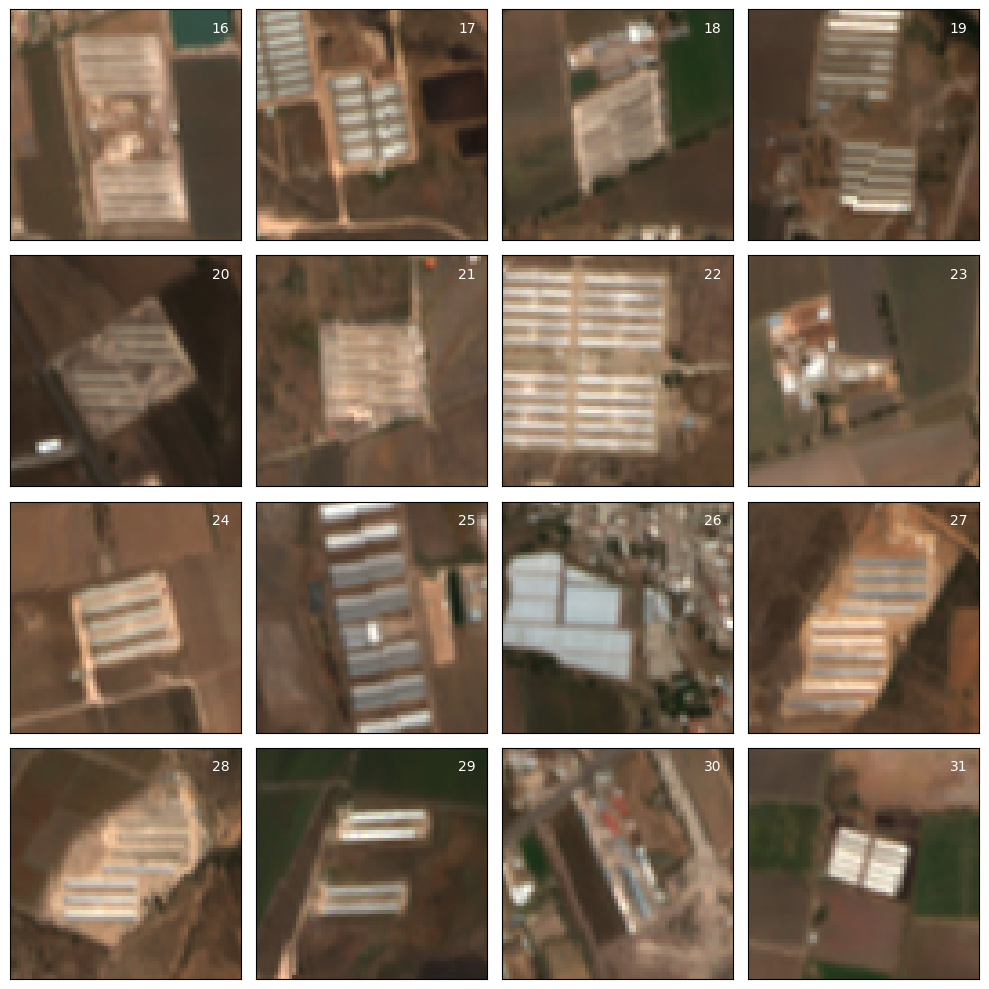

In [ ]:
# Examine images - if desired, manually record indexes of "mislabelled" images, which
# can then be used to move images between arrays

def verify_images(image_arr, start_at):

  print(f"Displaying images {start_at} - {start_at+16}")
  image_nums = [n for n in range(start_at+16 - start_at)]

  _, axes = plt.subplots(4, 4, figsize=(10, 10))
  n = 0
  for row in axes:
    for col in row:
      try:
        col.imshow(image_arr[start_at+n, :, :, :].astype(int))
      except IndexError:
        pass
      col.text(0.95, 0.95, str(start_at+n), va='top', ha='right', color='white', transform=col.transAxes)
      col.axes.get_xaxis().set_visible(False)
      col.axes.get_yaxis().set_visible(False)
      n += 1

  plt.tight_layout()

#0, 16, 32, 48, 64, 80, 96, 112, 128, 144, 160, 176, 192
verify_images(images_cat1, start_at=16)

In [ ]:
# Enter an image number on this line to see it on a map
to_examine = coords_cat1.loc[coords_cat1.index[[30]]]
dodgy_points = geemap.gdf_to_ee(to_examine)

Map3 = geemap.Map()
Map3.centerObject(dodgy_points.first(), 16)

sentinel_viz3 = {
    'min': 0,
    'max': 3000,
    'bands': sentinel_bands
}

Map3.add_basemap("HYBRID")
#Map3.addLayer(sentinel, sentinel_viz3, 'Sentinel')
Map3.addLayer(buildings, buildings_viz, "All buildings")
Map3.addLayer(cafo_coords, {'color':'purple', 'width':6}, "Pig+chicken+egg farms")
#Map3.addLayer(cafo_areas, farm_viz, "Farms for training")
#Map3.addLayer(not_cafo_areas, not_farm_viz, "Not-farms for training")
Map3.addLayer(dodgy_points, {'color':'red', 'width':6}, "Dodgy Images")

Map3

False negatives in the Yucatan CAFO dataset:
*   29 - Lemon farm (large building next to official record of [small?] CAFO)
*   91 - University campus with animal permit

False positives in the Yucatan not-CAFO dataset
*   0, 1, 2, 7, 8, 9, 10, 11, 13, 14, 23, 24, 25, 26, 35, 38, 43, 44, 46, 62, 73, 83, 84, 95, 100, 102, 106, 107, 117, 127, 128, 134
*   Incubadora samahil was in there somewhere

In [ ]:
# Images to be moved from the CAFO dataset to the not-CAFO dataset
idx1 = []
false_pos = coords_cat1.loc[coords_cat1.index[idx1]]

# Images to be moved from the not-CAFO dataset to the CAFO dataset
idx0 = [0, 1, 45, 66, 67, 104]
false_neg = coords_cat0.loc[coords_cat0.index[idx0]]

false_pos.to_file(f'/content/drive/MyDrive/CAFO_data/Mexico/{prefix}_false_pos.geojson',\
                  driver='GeoJSON')
false_neg.to_file(f'/content/drive/MyDrive/CAFO_data/Mexico/{prefix}_false_neg.geojson',\
                  driver='GeoJSON')

In [ ]:
# Remove not-CAFO images that in fact contain CAFOs, and add them to the array of CAFO images
# Remove the CAFO images that are in fact not CAFOs
# Then save the arrays.

# Remove CAFOs from not-CAFO dataset

cat0_cleaned = np.delete(images_cat0, idx0, axis=0)

# Make array of "new" CAFOs
temp = np.zeros_like(images_cat0)[0:len(idx0)]
for i in range(len(idx0)):
  temp[i] = images_cat0[idx0[i]]

# Add to end of original CAFO dataset
cat1_supplemented = np.vstack((images_cat1, temp))

# Remove not-CAFOs from CAFO dataset
cat1_supplemented = np.delete(cat1_supplemented, idx1, axis=0)

print(f"There are now {cat0_cleaned.shape[0]} cat0 images and {cat1_supplemented.shape[0]} cat1 images")

# Save edited arrays
np.save(f'/content/drive/MyDrive/CAFO_data/Mexico/{prefix}_cat0_edited.npy', cat0_cleaned)
np.save(f'/content/drive/MyDrive/CAFO_data/Mexico/{prefix}_cat1_edited.npy', cat1_supplemented)

There are now 194 cat0 images and 158 cat1 images
